Ok, quick outline:
1. Have the network to left
2. Have the network time series top center
3. Take three time windows
4. Have the seed map and winner takes all for each window in stack mid/bottom center
5. Have the average winner takes all / scores on right

In [100]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import multiprocessing as mp
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [119]:
def remap(vec, mask):
    # Remap the map into volume space
    vol = np.zeros_like(mask, dtype=np.float64)
    vol[mask] = vec
    
    return vol

In [120]:
def make_image(vec, mask_i):
    mask = mask_i.get_data() != 0
    vol = remap(vec, mask)
    img = nib.Nifti1Image(vol, affine=mask_i.get_affine(), header=mask_i.get_header())
    return img, vol

In [4]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [5]:
# Paths
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale012.nii.gz'
pheno_path = '/data1/abide/Pheno/merged_pheno.csv'
sub_path = '/data1/abide/Full/abide_release_sym_gsc0_lp01/Stanford/fmri_0051198_session_1_run1.nii.gz'

In [6]:
# Get the mask
m_img = nib.load(mask_path)
mask = m_img.get_data()!=0

In [49]:
# Get the subject
s_img = nib.load(sub_path)
data = s_img.get_data()[mask]

In [118]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()
part = prior[mask]

In [122]:
# Make an image of just network 8
net_8 = np.zeros_like(prior)
net_8[prior==8] = 1
net_8_img = nib.Nifti1Image(net_8, affine=m_img.get_affine(), header=m_img.get_header())

In [115]:
# Make a mean time series for network 8
net_data = data[part==8]
net_mean = np.mean(net_data,0)

In [8]:
# Make some sliding windows
n_img = data.shape[1]
sld_width = 80
window = np.arange(0,n_img-sld_width)

In [55]:
def get_net(w_id, windows, data, sld_width, part):
    # Get the correlation of the network average with the rest of the brain in the sliding window
    w_start = window[w_id]
    w_stop = w_start+sld_width
    sld_data = data[:,w_start:w_stop]

    n_img = sld_data.shape[1]
    n_vox = sld_data.shape[0]
    # Get the network average for all networks
    net_avg = np.zeros((12, n_img))
    net_corr = np.zeros((12, n_vox))
    for n_id, n_val in enumerate(np.arange(1,13)):
        net_avg[n_id] = np.mean(sld_data[part==n_val,...],0)
        net_corr[n_id, :] = np.array([np.corrcoef(sld_data[i,:],net_avg[n_id,:])[0,1] for i in np.arange(n_vox)])
    
    bin_part = np.argmax(net_corr,0)
    
    return net_avg, net_corr, bin_part

In [57]:
s1 = 10
s2 = 70
s3 = 130

In [84]:
def run_par(args):
    w, window, data, sld_width, part = args
    a1, c1, p1 = get_net(w, window, data, sld_width, part)
    np1 = np.zeros(part.shape)
    np1[p1==7] = 1
    out = make_image(np1, m_img)[1]
    
    return out

In [82]:
job_list = list()
for w_id, w in enumerate(window):
    job_list.append((w, window, data, sld_width, part))

In [83]:
p = mp.Pool(processes=7)
results = p.map(run_par, job_list)

Running w 1
Running w 7
Running w 13
Running w 19
Running w 25
Running w 31
Running w 37
Running w 2Running w 8Running w 14Running w 20Running w 26Running w 32Running w 38






Running w 3Running w 9Running w 15Running w 21Running w 27Running w 33Running w 39






Running w 4Running w 10Running w 16Running w 22Running w 28Running w 34Running w 40






Running w 5Running w 11Running w 17Running w 23Running w 29Running w 35Running w 41






Running w 6Running w 12Running w 18Running w 24Running w 30Running w 36Running w 42






Running w 43Running w 55Running w 49Running w 67Running w 61Running w 73Running w 79






Running w 44Running w 56Running w 50Running w 68Running w 62Running w 74Running w 80






Running w 45Running w 57Running w 51Running w 69Running w 63Running w 75Running w 81






Running w 46Running w 58Running w 52Running w 70Running w 64Running w 76Running w 82






Running w 47Running w 59Running w 53Running w 71Running w 65Running w 77Running w 83






Running 

In [89]:
net1 = np.zeros_like(mask, dtype=float)
for res in results:
    net1 += res
net1 = net1/len(res)

In [95]:
ni_avg1 = nib.Nifti1Image(net1, affine=m_img.get_affine(), header=m_img.get_header())

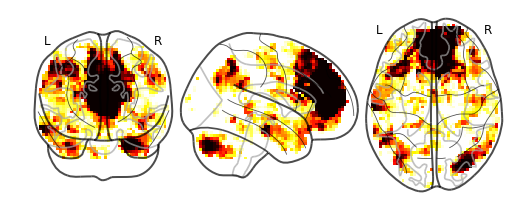

In [94]:
nlp.plot_glass_brain(ni1)

In [107]:
a1, c1, p1 = get_net(s1, window, data, sld_width, part)
np1 = np.zeros_like(part)
np1[p1==7] = 1
ni1 = make_image(np1, m_img)
ci1 = make_image(c1[7,:], m_img)

a2, c2, p2 = get_net(s2, window, data, sld_width, part)
np2 = np.zeros_like(part)
np2[p2==7] = 1
ni2 = make_image(np2, m_img)
ci2 = make_image(c2[7,:], m_img)

a3, c3, p3 = get_net(s3, window, data, sld_width, part)
np3 = np.zeros_like(part)
np3[p3==7] = 1
ni3 = make_image(np3, m_img)
ci3 = make_image(c3[7,:], m_img)

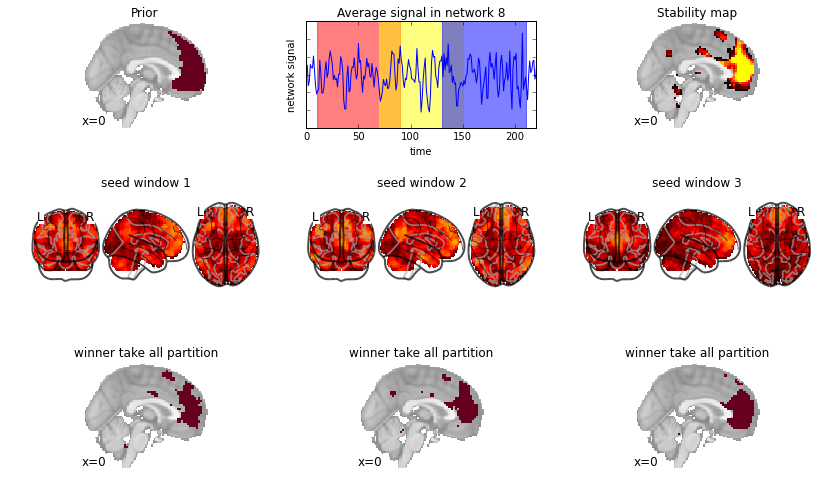

In [138]:
# Make a static figure
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 3, hspace=0.6)
ax_prior = fig.add_subplot(gs[0,0])
nlp.plot_stat_map(net_8_img, axes=ax_prior, colorbar=False, display_mode='x', cut_coords=(0,), cmap=cm.RdBu_r)
ax_prior.set_title('Prior')

ax_time = fig.add_subplot(gs[0,1])
ax_time.plot(net_mean)
ax_time.axvspan(window[s1], window[s1]+sld_width, color='red', alpha=0.5)
ax_time.axvspan(window[s2], window[s2]+sld_width, color='yellow', alpha=0.5)
ax_time.axvspan(window[s3], window[s3]+sld_width, color='blue', alpha=0.5)
ax_time.set_xlim([0,220])
ax_time.set_xlabel('time')
ax_time.set_ylabel('network signal')
ax_time.set_title('Average signal in network 8')
ax_time.set_yticklabels([])

ax_stab = fig.add_subplot(gs[0,2])
nlp.plot_stat_map(ni_avg1, axes=ax_stab, colorbar=False, display_mode='x', cut_coords=(0,), cmap=hotcold)
ax_stab.set_title('Stability map')

ax_corr1 = fig.add_subplot(gs[1,0])
nlp.plot_glass_brain(ci1[0], cmap=hotcold, axes=ax_corr1, vmin=-1, vmax=1)
ax_corr1.set_title('seed window 1')

ax_bin1 = fig.add_subplot(gs[2,0])
nlp.plot_stat_map(ni1[0], axes=ax_bin1, colorbar=False, display_mode='x', cut_coords=(0,), cmap=cm.RdBu_r)
ax_bin1.set_title('winner take all partition')

ax_corr2 = fig.add_subplot(gs[1,1])
nlp.plot_glass_brain(ci2[0], cmap=hotcold, axes=ax_corr2, vmin=-1, vmax=1)
ax_corr2.set_title('seed window 2')

ax_bin2 = fig.add_subplot(gs[2,1])
nlp.plot_stat_map(ni2[0], axes=ax_bin2, colorbar=False, display_mode='x', cut_coords=(0,), cmap=cm.RdBu_r)
ax_bin2.set_title('winner take all partition')

ax_corr3 = fig.add_subplot(gs[1,2])
nlp.plot_glass_brain(ci3[0], cmap=hotcold, axes=ax_corr3, vmin=-1, vmax=1)
ax_corr3.set_title('seed window 3')

ax_bin3 = fig.add_subplot(gs[2,2])
nlp.plot_stat_map(ni3[0], axes=ax_bin3, colorbar=False, display_mode='x', cut_coords=(0,), cmap=cm.RdBu_r)
ax_bin3.set_title('winner take all partition')
fig.savefig('static_figure.svg', dpi=300)

In [140]:
pwd

u'/home/surchs/Code/Projects/preventad'